In [1]:
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')

import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['science', 'notebook'])

import scipy.special as sc
import pandas as pd
import pymc as pm
import arviz as az
import corner

import aesara
import aesara.tensor as at
from aesara.compile.ops import as_op

In [2]:
bandwidth_mono = 550
bandwidth = np.arange(530, 901, 10) # rentang sesuai kurva transmisi

bandwidth

array([530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650,
       660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780,
       790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900])

In [3]:
x_data = np.linspace(-100, 100, 500)

d_moon = 384400 # satuan km
x0 = 0.
A = 1000.
# σ_true = 250.
T = 5800.

In [4]:
# from scipy.interpolate import interp1d

# f_interp = interp1d(x, y, kind='cubic')

In [5]:
def Planck(λ, T): 
    """
    λ: dalam cm
    T: dalam K
    """
    a = 3.7412e-5 / ((λ * 1e-7) **5) # 1e-7 adalah konversi dari nm ke cm
    b = np.exp(1.43879/(λ * 1e-7 * T)) - 1
    return a/b

In [6]:
def fresnel_monokromatik(x, x0, d, A):
    y0 = np.zeros(len(x))
    w = (x - x0) * np.sqrt(2 / (bandwidth_mono * d)) * np.sqrt(1. / 1e-6) # faktor konversi ke satuan meter
    cc, ss = sc.fresnel(w)
    y = A * 0.5 * ((cc + 0.5)**2 + (ss + 0.5)**2)
    y_new = (Planck(bandwidth_mono, T)/den) * y
    y0 += y_new
    return y0

def fresnel_polikromatik(x, x0, d, A):
    y0 = np.zeros(len(x))
    for i in range (len(bandwidth)):
        w = (x - x0) * np.sqrt(2 / (bandwidth[i] * d)) * np.sqrt(1. / 1e-6) # faktor konversi ke satuan meter
        cc, ss = sc.fresnel(w)
        y = A * 0.5 * ((cc + 0.5)**2 + (ss + 0.5)**2)
        y_new = (Planck(bandwidth[i], T)/den) * y
        y0 += y_new
    return y0

In [7]:
x_val = np.arange(200, 2000)
y_val = Planck(x_val, 5800)

den = np.max(y_val)

y_data_mono = fresnel_monokromatik(x_data, x0, d_moon, A)
y_data = fresnel_polikromatik(x_data, x0, d_moon, A)
# y_data_mono = fresnel_monokromatik(x_data, x0, d_moon, A)
y_data_mono = np.random.normal(y_data_mono)
y_data = np.random.normal(y_data)

y_data_mono_scaled = y_data_mono / (y_data_mono.std()*2)
y_data_scaled = y_data / (y_data.std()*2)

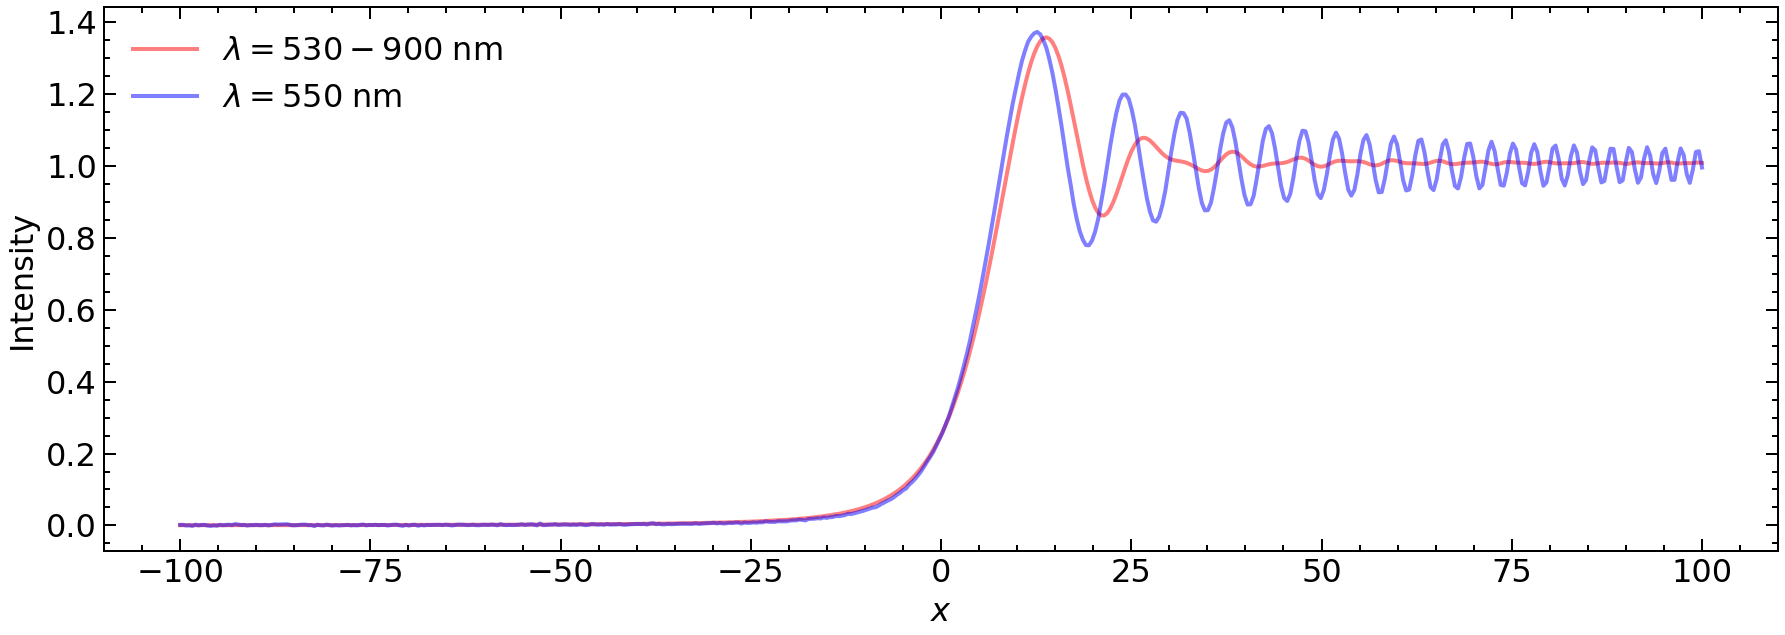

In [11]:
# plt.figure(figsize = (12,5), facecolor='w')
plt.figure(figsize = (15,5))
# plt.scatter(x_data, y_data_mono_scaled, marker='.', c='b', alpha=0.3)
# plt.scatter(x_data, y_data_scaled, marker='.', c='r', alpha=0.3)
plt.plot(x_data, y_data_scaled, 'r-', lw=2, alpha=0.5)
plt.plot(x_data, y_data_mono_scaled, 'b-', lw=2, alpha=0.5)
plt.xlabel(r'$x$')
plt.ylabel('Intensity')
plt.legend(['$\lambda = 530 - 900\; \mathrm{nm}$', '$\lambda = 550\; \mathrm{nm}$'], loc='upper left')
plt.savefig('monovspoli.pdf')